<a href="https://colab.research.google.com/github/dantv2002/PracticeML/blob/main/review_transfer_learning_resnet_fruits360.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import itertools

In [ ]:
# Download data
# https://www.kaggle.com/moltean/fruits
!wget -nc https://archive.org/download/fruits-360/fruits-360.zip

--2024-01-13 16:21:49--  https://archive.org/download/fruits-360/fruits-360.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia601203.us.archive.org/24/items/fruits-360/fruits-360.zip [following]
--2024-01-13 16:21:50--  https://ia601203.us.archive.org/24/items/fruits-360/fruits-360.zip
Resolving ia601203.us.archive.org (ia601203.us.archive.org)... 207.241.227.133
Connecting to ia601203.us.archive.org (ia601203.us.archive.org)|207.241.227.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190820824 (182M) [application/zip]
Saving to: ‘fruits-360.zip’

fruits-360.zip      100%[===================>] 181.98M   486KB/s    in 4m 56s  

2024-01-13 16:26:47 (629 KB/s) - ‘fruits-360.zip’ saved [190820824/190820824]



In [ ]:
!unzip -nq fruits-360.zip
!ls

fruits-360  fruits-360.zip  sample_data


In [ ]:
!rm fruits-360.zip
!ls

fruits-360  sample_data


In [ ]:
# this is size of dataset 100x100px
IMAGE_SIZE = [100, 100]

# training config:
epochs = 15
batch_size = 128

train_path = 'fruits-360/Training'
valid_path = 'fruits-360/Validation'

# get number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')
# get number of classes
folders = glob(train_path + '/*')

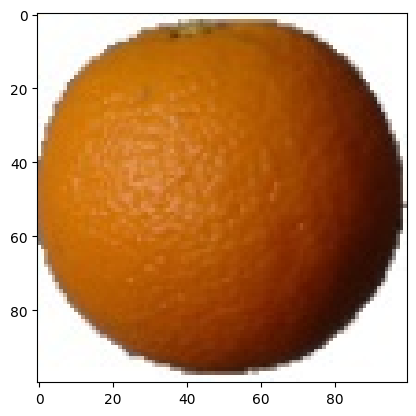

In [ ]:
# pick up an image
plt.imshow(image.load_img(np.random.choice(image_files)));

In [ ]:
# resnet base
res = ResNet50(
    input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
# don't train existing weights
for layer in res.layers:
  layer.trainable = False

In [ ]:
# layer
x = Flatten()(res.output)
x = Dense(1000, activation='relu')(x)
x = Dropout(0.3)(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
# Create the model then compile
model = Model(inputs=res.input, outputs=prediction)

model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 106, 106, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 50, 50, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 50, 50, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# create an instance of ImageDataGenerator
train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [ ]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 9673 images belonging to 60 classes.
{'Apple Braeburn': 0, 'Apple Golden 1': 1, 'Apple Golden 2': 2, 'Apple Golden 3': 3, 'Apple Granny Smith': 4, 'Apple Red 1': 5, 'Apple Red 2': 6, 'Apple Red 3': 7, 'Apple Red Delicious': 8, 'Apple Red Yellow': 9, 'Apricot': 10, 'Avocado': 11, 'Avocado ripe': 12, 'Banana': 13, 'Banana Red': 14, 'Cactus fruit': 15, 'Carambula': 16, 'Cherry': 17, 'Clementine': 18, 'Cocos': 19, 'Dates': 20, 'Granadilla': 21, 'Grape Pink': 22, 'Grape White': 23, 'Grape White 2': 24, 'Grapefruit Pink': 25, 'Grapefruit White': 26, 'Guava': 27, 'Huckleberry': 28, 'Kaki': 29, 'Kiwi': 30, 'Kumquats': 31, 'Lemon': 32, 'Lemon Meyer': 33, 'Limes': 34, 'Litchi': 35, 'Mandarine': 36, 'Mango': 37, 'Maracuja': 38, 'Nectarine': 39, 'Orange': 40, 'Papaya': 41, 'Passion Fruit': 42, 'Peach': 43, 'Peach Flat': 44, 'Pear': 45, 'Pear Abate': 46, 'Pear Monster': 47, 'Pear Williams': 48, 'Pepino': 49, 'Pineapple': 50, 'Pitahaya Red': 51, 'Plum': 52, 'Pomegranate': 53, 'Quince': 54, 'Ra

min: -103.939 max: 151.061


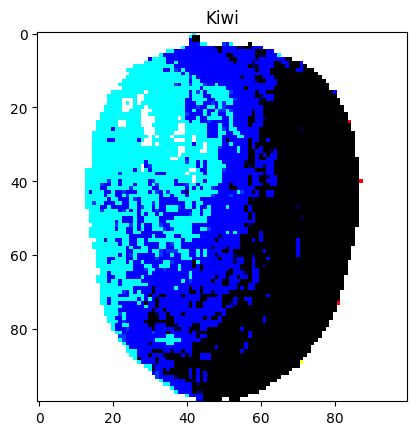

In [ ]:
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [ ]:
# create generators
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=False,
  batch_size=batch_size,
  class_mode='sparse',
)

Found 28736 images belonging to 60 classes.
Found 9673 images belonging to 60 classes.


In [ ]:
logs = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/15
224/224 [==============================] - 174s 736ms/step - loss: 0.9132 - accuracy: 0.8750 - val_loss: 0.1196 - val_accuracy: 0.9633
Epoch 2/15
224/224 [==============================] - 120s 535ms/step - loss: 0.1557 - accuracy: 0.9561 - val_loss: 0.0574 - val_accuracy: 0.9793
Epoch 3/15
224/224 [==============================] - 113s 504ms/step - loss: 0.1125 - accuracy: 0.9684 - val_loss: 0.0623 - val_accuracy: 0.9823
Epoch 4/15
224/224 [==============================] - 111s 498ms/step - loss: 0.1213 - accuracy: 0.9690 - val_loss: 0.1126 - val_accuracy: 0.9718
Epoch 5/15
224/224 [==============================] - 113s 504ms/step - loss: 0.1454 - accuracy: 0.9681 - val_loss: 0.1381 - val_accuracy: 0.9723
Epoch 6/15
224/224 [==============================] - 111s 496ms/step - loss: 0.1412 - accuracy: 0.9718 - val_loss: 0.1167 - val_accuracy: 0.9732
Epoch 7/15
224/224 [==============================] - 113s 502ms/step - loss: 0.1004 - accuracy: 0.9787 - val_loss: 0.0522 -

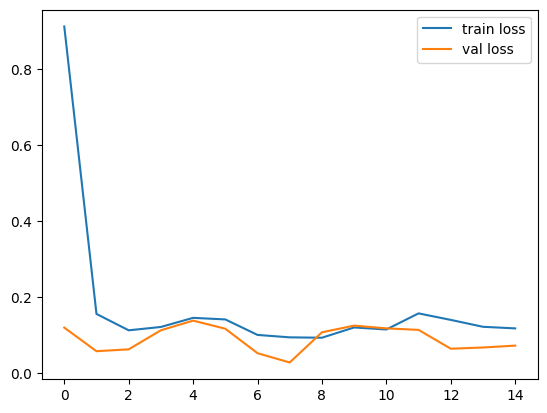

In [ ]:
# plot loss
plt.plot(logs.history['loss'], label='train loss')
plt.plot(logs.history['val_loss'], label='val loss')
plt.legend();
plt.show()

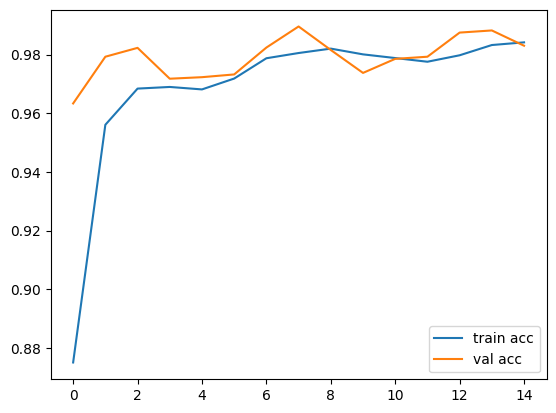

In [ ]:
# plot accuracies
plt.plot(logs.history['accuracy'], label='train acc')
plt.plot(logs.history['val_accuracy'], label='val acc')
plt.legend();

In [ ]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  n_images = 0
  for x, y in val_gen.flow_from_directory(
      data_path,
      target_size=IMAGE_SIZE,
      shuffle=False,
      batch_size=batch_size * 2):
    i += 1
    n_images += len(y)
    if i % 50 == 0:
      print(f'{n_images} images processed.')
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [ ]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 28736
Found 28736 images belonging to 60 classes.
8/8 [==============================] - 0s 27ms/step
12800 images processed.
8/8 [==============================] - 0s 28ms/step
25600 images processed.
2/2 [==============================] - 0s 25ms/step
[[492   0   0 ...   0   0   0]
 [  0 492   0 ...   0   0   0]
 [  0   0 476 ...   0   0   0]
 ...
 [  0   0   0 ... 492   0   0]
 [  0   0   0 ...   0 490   0]
 [  0   0   0 ...   0   0 486]]
Generating confusion matrix 9673
Found 9673 images belonging to 60 classes.
7/7 [==============================] - 2s 170ms/step
[[164   0   0 ...   0   0   0]
 [  0 163   0 ...   0   0   0]
 [  0   0 117 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 166   0]
 [  0   0   0 ...   0   0 164]]


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.figure(figsize=(15, 15))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[492   0   0 ...   0   0   0]
 [  0 492   0 ...   0   0   0]
 [  0   0 476 ...   0   0   0]
 ...
 [  0   0   0 ... 492   0   0]
 [  0   0   0 ...   0 490   0]
 [  0   0   0 ...   0   0 486]]


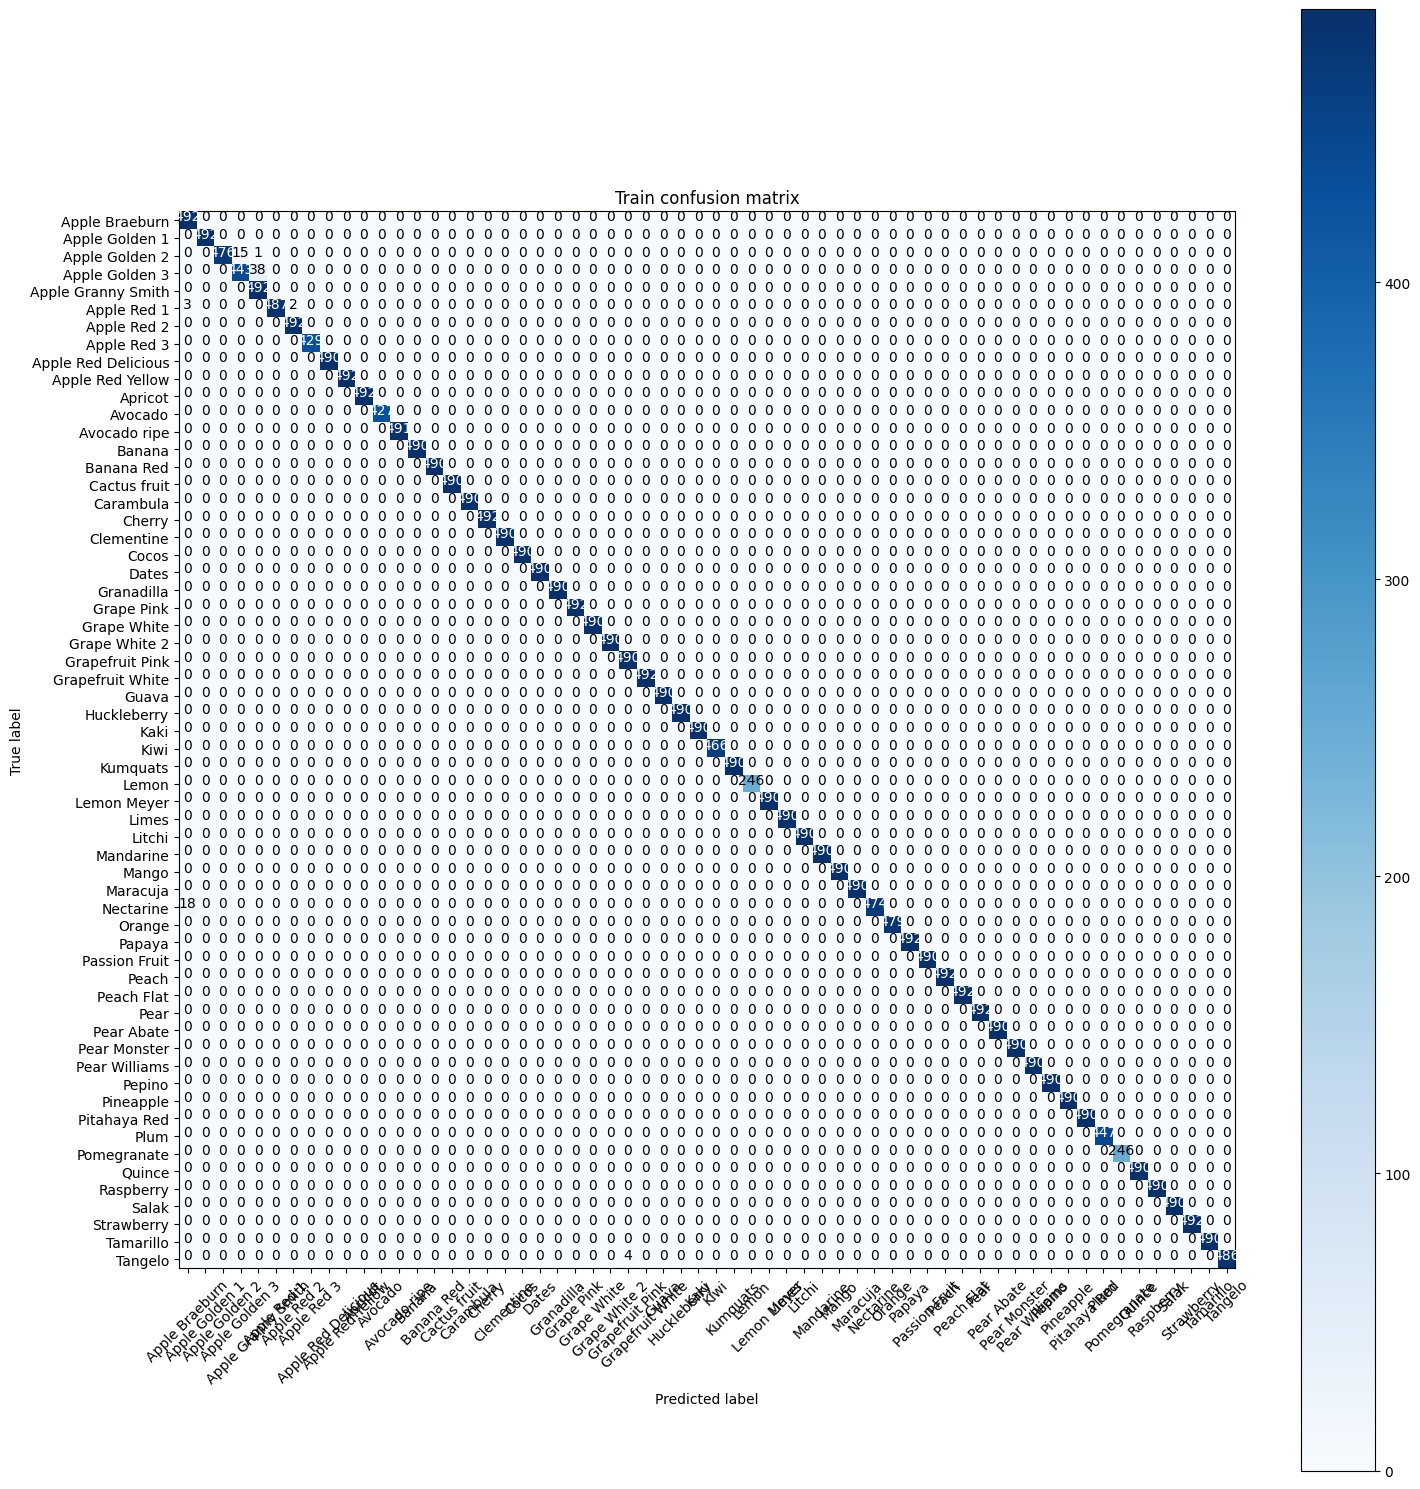

In [ ]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')

Confusion matrix, without normalization
[[164   0   0 ...   0   0   0]
 [  0 163   0 ...   0   0   0]
 [  0   0 117 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 166   0]
 [  0   0   0 ...   0   0 164]]


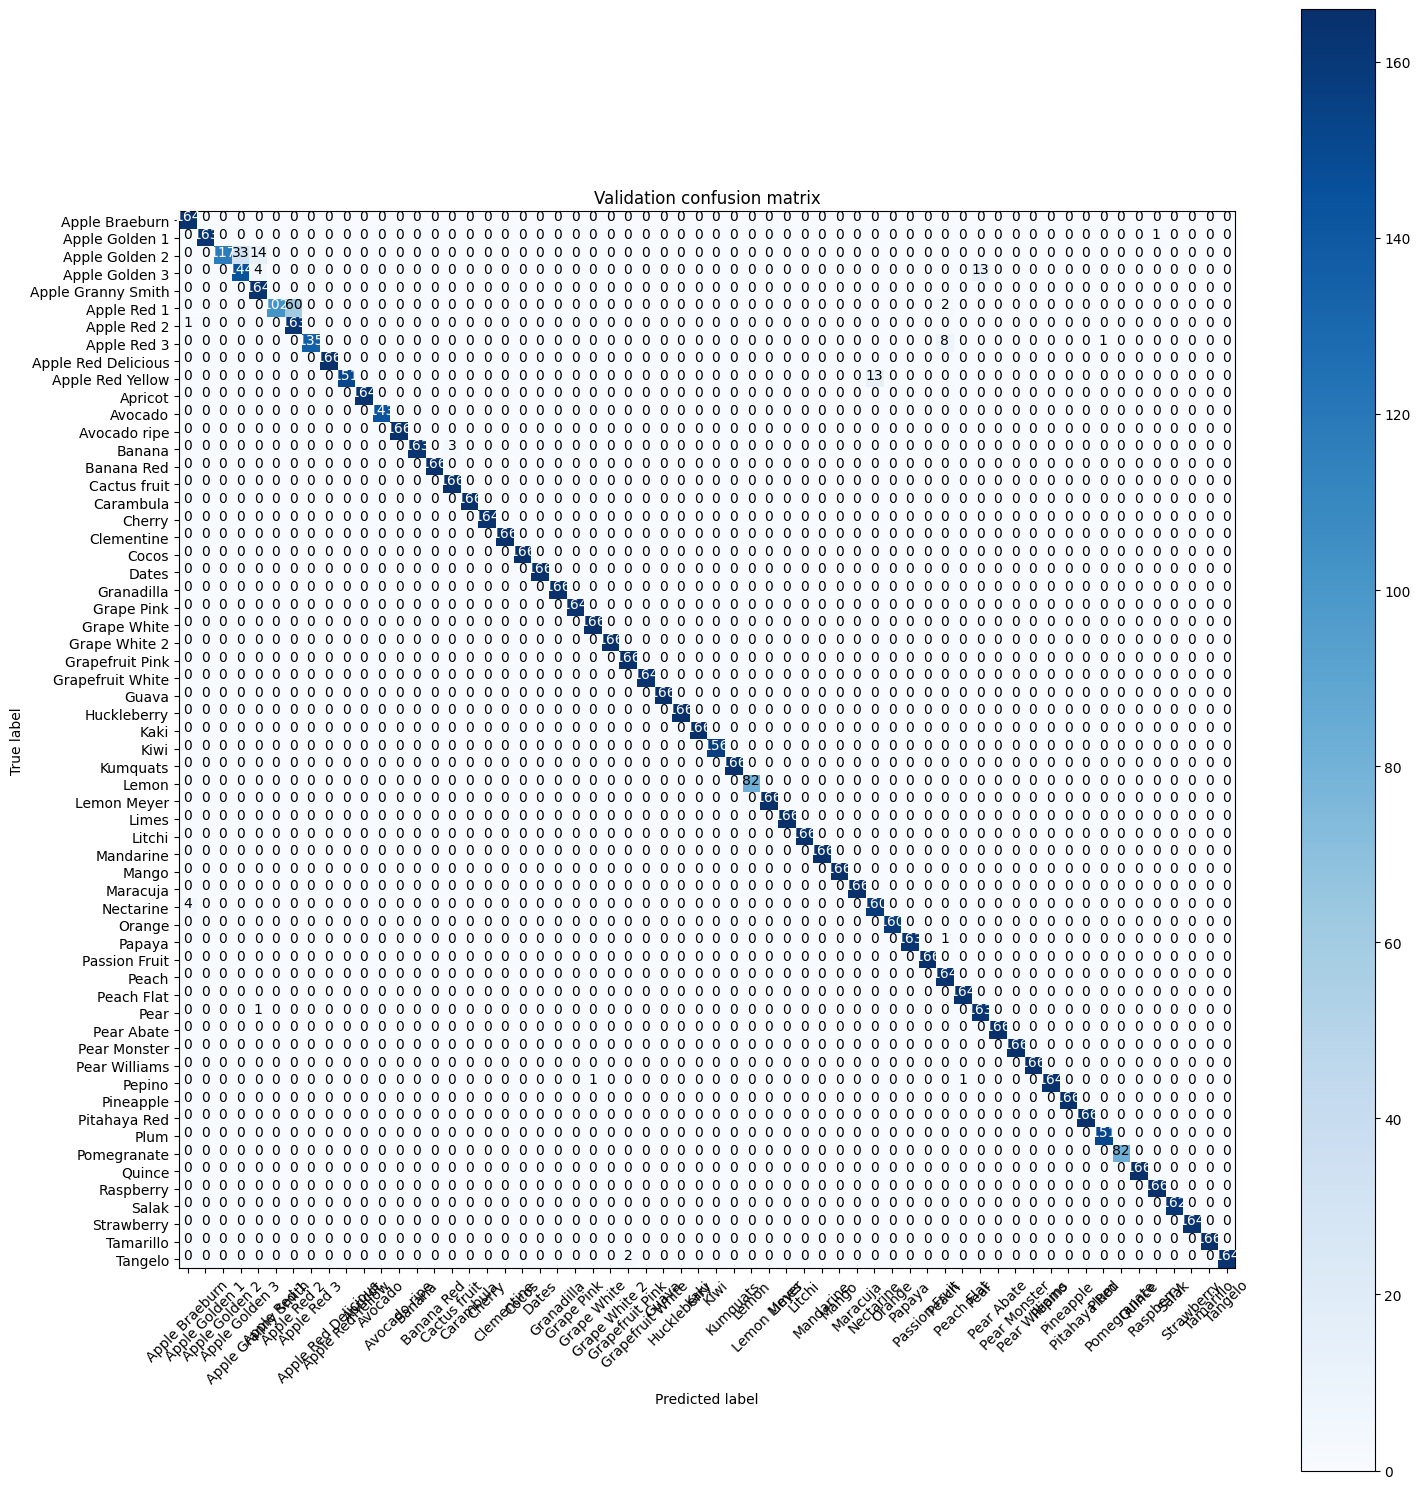

In [ ]:
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')